### Get the BSDS500 dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
!wget https://raw.githubusercontent.com/leelening/rbe549/main/hw0/BSDS500.tar.xz
!tar -xvf BSDS500.tar.xz
!mv BSDS500/ /content/data/

In [ ]:
!wget https://raw.githubusercontent.com/leelening/rbe549/main/hw0/TxtFiles.tar.xz
!tar -xvf TxtFiles.tar.xz
!mv TxtFiles/ /content/data/

--2024-03-01 22:20:38--  https://raw.githubusercontent.com/leelening/rbe549/main/hw0/TxtFiles.tar.xz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55376 (54K) [application/octet-stream]
Saving to: ‘TxtFiles.tar.xz’

TxtFiles.tar.xz     100%[===================>]  54.08K  --.-KB/s    in 0.004s  

2024-03-01 22:20:38 (13.7 MB/s) - ‘TxtFiles.tar.xz’ saved [55376/55376]

TxtFiles/
TxtFiles/DirNamesTest.txt
TxtFiles/DirNamesTrain.txt
TxtFiles/LabelsTest.txt
TxtFiles/LabelsTrain.txt


In [ ]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import pandas as pd

%cd /content/drive/MyDrive/AutoPano/Phase2

/content/drive/.shortcut-targets-by-id/1CLiZb_fMfgNhTkiGrkTxoIDZascu1b9x/AutoPano/Phase2


In [ ]:

def extract_patch(image, patch_size, rho):
    M, N, _ = image.shape
    Mp, Np = patch_size

    max_x = N - Np - rho
    max_y = M - Mp - rho
    # print(max_y, N, M)

    x = np.random.randint(rho, max_x + 1)
    y = np.random.randint(rho, max_y + 1)



    top_left = (x, y)
    top_right = (x + Np, y)
    bottom_left = (x, y + Mp)
    bottom_right = (x + Np, y + Mp)

    patch = image[y:y+Mp, x:x+Np]
    # print("Displaying from extract_patch")
    # cv2_imshow(patch)
    return image, patch, top_left, top_right, bottom_left, bottom_right


def perform_perturbation(image, patch, rho, top_left, top_right, bottom_left, bottom_right):

    px_tl = np.random.uniform(-rho, rho)
    py_tl = np.random.uniform(-rho, rho)

    px_tr = np.random.uniform(-rho, rho)
    py_tr = np.random.uniform(-rho, rho)

    px_bl = np.random.uniform(-rho, rho)
    py_bl = np.random.uniform(-rho, rho)

    px_br = np.random.uniform(-rho, rho)
    py_br = np.random.uniform(-rho, rho)

    top_left_perturbed = (int(top_left[0] + px_tl), int(top_left[1] + py_tl))
    top_right_perturbed = (int(top_right[0] + px_tr), int(top_right[1] + py_tr))
    bottom_left_perturbed = (int(bottom_left[0] + px_bl), int(bottom_left[1] + py_bl))
    bottom_right_perturbed = (int(bottom_right[0] + px_br), int(bottom_right[1] + py_br))
    image_unaltered = image.copy()
    cv2.line(image, top_left_perturbed, top_right_perturbed, (0, 0, 255), 2)
    cv2.line(image, top_right_perturbed, bottom_right_perturbed, (0, 0, 255), 2)
    cv2.line(image, bottom_right_perturbed, bottom_left_perturbed, (0, 0, 255), 2)
    cv2.line(image, bottom_left_perturbed, top_left_perturbed, (0, 0, 255), 2)
    # print("Unaltered image")
    # cv2_imshow(image_unaltered)
    return image, patch, top_left_perturbed, top_right_perturbed, bottom_left_perturbed, bottom_right_perturbed,image_unaltered

def warp_image(image, original_points, perturbed_points):
    H = cv2.getPerspectiveTransform(np.float32(original_points), np.float32(perturbed_points))
    H_inv = np.linalg.inv(H)
    warped_image = cv2.warpPerspective(image, H_inv, (image.shape[1], image.shape[0]))
    transformed_points = cv2.perspectiveTransform(np.array([perturbed_points], dtype=np.float32), H_inv)[0]
    unaltered = warped_image.copy()
    for point in transformed_points:
        cv2.circle(warped_image, tuple(np.round(point).astype(int)), 5, (0, 255, 0), -1)

    min_x = int(np.min(transformed_points[:, 0]))
    max_x = int(np.max(transformed_points[:, 0]))
    min_y = int(np.min(transformed_points[:, 1]))
    max_y = int(np.max(transformed_points[:, 1]))
    warped_patch = warped_image[min_y:max_y, min_x:max_x]
    unaltered_patch = unaltered[min_y:max_y, min_x:max_x]
    # print("From warp image- unaltered patch")
    # cv2_imshow(unaltered_patch)
    return warped_image, warped_patch, unaltered_patch


def homography(perturbed_points, original_points):
    H4pt = np.zeros((4, 2))
    for i in range(4):
        delta_u = perturbed_points[i][0] - original_points[i][0]
        delta_v = perturbed_points[i][1] - original_points[i][1]

        H4pt[i][0] = delta_u
        H4pt[i][1] = delta_v

    return H4pt





In [ ]:
current_directory = os.getcwd()
image_directory = "/content/drive/MyDrive/AutoPano/Phase2/Data/Train/"
res_directory = "/content/drive/MyDrive/AutoPano/Phase2/Data"
# image = cv2.imread(os.path.join(image_directory, "75.jpg"))


stacked_patches = []
file_list = os.listdir(image_directory)
H_4 = []
image_names = []
# Iterate over each file in the directory
for filename in file_list:
    # Check if the file is an image (you can add more image extensions if needed)
    if filename.endswith(('.jpg', '.jpeg', '.png')):
        # Read the image using OpenCV
        image = cv2.imread(os.path.join(image_directory, filename))
        # image_names.append()
        patch_size = (100,100)
        rho = 15
        # print(image.shape)
        image_with_patch, patch, tl, tr, bl, br = extract_patch(image, patch_size, rho)
        patch1 = patch.copy()
        perturbed_image, perturbed_patch, tlp, trp, blp, brp, unaltered1 = perform_perturbation(image_with_patch, patch1, rho, tl, tr, bl, br)
        # print("Unaltered image")
        # cv2_imshow(unaltered)
        original_points = [tl, tr, bl, br]
        perturbed_points = [tlp, trp, blp, brp]

        pts2 = np.array(perturbed_points)
        pts1 = np.array(original_points)
        H_dist = (pts2-pts1).astype(np.float32)


        #Flatten
        H_dist = np.hstack((H_dist[:,0] , H_dist[:,1]))
        H_4.append(H_dist)
        # print(H_4)
        warped_image, warped_patch, unaltered2 = warp_image(perturbed_image, original_points, perturbed_points)
        warped_image1, warped_patch1, unaltered3 = warp_image(unaltered1, original_points, perturbed_points)

        H4pt = homography(perturbed_points, original_points)
        stack = np.dstack((patch1, unaltered3))
        stacked_patches.append(stack)
        patchA = '/PatchA/' + str(filename)
        cv2.imwrite((res_directory + patchA), patch1)
        patchB = '/Patch_warped/' + str(filename)
        cv2.imwrite((res_directory+ patchB), unaltered3)
        print('Done for '+filename)
        # break
# plt.imshow(patch)
# plt.show()

# cv2_imshow(patch)
# cv2_imshow(warped_patch)
# cv2_imshow(perturbed_image)
# cv2_imshow(warped_image)
# cv2_imshow(unaltered)



# cv2_imshow(patch1)
# cv2_imshow(unaltered3)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [ ]:
current_directory = os.getcwd()
image_directory = "/content/drive/MyDrive/AutoPano/Phase2/Data/Val/"
res_directory = "/content/drive/MyDrive/AutoPano/Phase2/Data"
# image = cv2.imread(os.path.join(image_directory, "75.jpg"))


stacked_patches = []
file_list = os.listdir(image_directory)
H_4 = []
image_names = []
# Iterate over each file in the directory
for filename in file_list:
    # Check if the file is an image (you can add more image extensions if needed)
    if filename.endswith(('.jpg', '.jpeg', '.png')):
        # Read the image using OpenCV
        image = cv2.imread(os.path.join(image_directory, filename))
        # image_names.append()
        patch_size = (100,100)
        rho = 15
        # print(image.shape)
        image_with_patch, patch, tl, tr, bl, br = extract_patch(image, patch_size, rho)
        patch1 = patch.copy()
        perturbed_image, perturbed_patch, tlp, trp, blp, brp, unaltered1 = perform_perturbation(image_with_patch, patch1, rho, tl, tr, bl, br)
        # print("Unaltered image")
        # cv2_imshow(unaltered)
        original_points = [tl, tr, bl, br]
        perturbed_points = [tlp, trp, blp, brp]

        pts2 = np.array(perturbed_points)
        pts1 = np.array(original_points)
        H_dist = (pts2-pts1).astype(np.float32)


        #Flatten
        H_dist = np.hstack((H_dist[:,0] , H_dist[:,1]))
        H_4.append(H_dist)
        # print(H_4)
        warped_image, warped_patch, unaltered2 = warp_image(perturbed_image, original_points, perturbed_points)
        warped_image1, warped_patch1, unaltered3 = warp_image(unaltered1, original_points, perturbed_points)

        H4pt = homography(perturbed_points, original_points)
        stack = np.dstack((patch1, unaltered3))
        stacked_patches.append(stack)
        patchA = '/PatchA_val/' + str(filename)
        cv2.imwrite((res_directory + patchA), patch1)
        patchB = '/Patch_warped_val/' + str(filename)
        cv2.imwrite((res_directory+ patchB), unaltered3)
        print('Done for '+filename)
        # break
# plt.imshow(patch)
# plt.show()

# cv2_imshow(patch)
# cv2_imshow(warped_patch)
# cv2_imshow(perturbed_image)
# cv2_imshow(warped_image)
# cv2_imshow(unaltered)



# cv2_imshow(patch1)
# cv2_imshow(unaltered3)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [ ]:
df = pd.DataFrame(H_4)
df.to_csv("/content/drive/MyDrive/AutoPano/Phase2/H4_val.csv", index=False)

In [ ]:
!pip install pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.6/801.6 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 36.8 MB/s eta 0:00:00


## Phase 2

### Neural Network Construction

In [ ]:
import torch
import pytorch_lightning as p1
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

def accuracy(outputs, labels):
    # _, preds = torch.max(outputs, dim=1)
    # return torch.tensor(torch.sum(preds == labels).item() / len(preds))
    return torch.mean(torch.abs(outputs - labels))


def loss_fn(out, labels):
    ###############################################
    # Fill your loss function of choice here!
    ###############################################
    loss_func = nn.MSELoss()
    labels = labels.float()
    loss = torch.sqrt(loss_func(out,labels))
    return loss

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = loss_fn(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = loss_fn(out, labels)   # Calculate loss
        mae = accuracy(out, labels)           # Calculate accuracy
        return {'loss': loss.detach(), 'mae': mae}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['mae'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'loss': epoch_loss.item(), 'mae': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], loss: {:.4f}, mae: {:.4f}".format(epoch, result['loss'], result['mae']))



class HomographyModel(p1.LightningModule):
  def __init__(self): #, InputSize, OutputSize):
      """
      Inputs:
      InputSize - Size of the Input
      OutputSize - Size of the Output
      """
      #############################
      # Fill your network initialization of choice here!
      #############################

      ####### NOTES:
      # -unsure about the channel values! 6 cuz 3 of patch1 + 3 of patch2
      # -do we even want batch normalization?
      # -should in channels be 3 bc of rgb?
      # -network.py of the other prof's file has regressor & spatial transformers, may need that?
      #######

      super().__init__()
      #################3
      self.layer1Conv = nn.Conv2d(in_channels=2, out_channels=64, kernel_size=3, padding=1, stride=1)
      self.layer1batch = nn.BatchNorm2d(64)
      self.layer1relu = nn.ReLU()

      #################
      self.layer2Conv = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, stride=1)
      self.layer2batch = nn.BatchNorm2d(64)
      self.layer2relu = nn.ReLU()

      # self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

      ###############3
      self.layer3Conv = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1)
      self.layer3batch = nn.BatchNorm2d(128)
      self.layer3relu = nn.ReLU()

     #################3
      self.layer4Conv = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, stride=1)
      self.layer4batch = nn.BatchNorm2d(128)
      self.layer4relu = nn.ReLU()

      # self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
      #############33

    #   self.layer5Conv = nn.Conv2d(in_channels=50, out_channels=32, kernel_size=3, padding='same')
    #   self.layer5batch = nn.BatchNorm2d(32)
    #   self.layer5relu = nn.ReLU()

    # #########################
    #   self.layer6Conv = nn.Conv2d(in_channels=32, out_channels=20, kernel_size=3, padding='same')
    #   self.layer6batch = nn.BatchNorm2d(20)
    #   self.layer6relu = nn.ReLU()

    #   self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

    # ########################
    #   self.layer7Conv = nn.Conv2d(in_channels=20, out_channels=16, kernel_size=3, padding='same')
    #   self.layer7batch = nn.BatchNorm2d(16)
    #   self.layer7relu = nn.ReLU()

      # #conv8 16x16x128
      # self.layer4Conv = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding='same')
      # self.layer4batch = nn.BatchNorm2d(16)
      # self.layer4relu = nn.ReLU()
      self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
      self.dropout = nn.Dropout(0.5)
      #FC 1024, FC 8x21, softmax
      self.fc1 = nn.Linear(18432, 1024)
      self.fc2 = nn.Linear(1024, 8)
      # self.layer3 = nn.Softmax2d(32,8,21) #softmax 8x21 ?


  def forward(self, xb):
      """
      Input:
      xb is a MiniBatch of the current image
      Outputs:
      out - output of the network
      """
      #############################
      # Fill your network structure of choice here!
      #############################
      #unsure about the values!
      # print(xb.shape)
      x = self.layer1relu(self.layer1batch(self.layer1Conv(xb)))
      x = self.layer2relu(self.layer2batch(self.layer2Conv(x)))
      x = self.maxpool(x)
      x = self.layer2relu(self.layer2batch(self.layer2Conv(x)))
      x = self.layer2relu(self.layer2batch(self.layer2Conv(x)))
      x = self.maxpool(x)
      x = self.layer3relu(self.layer3batch(self.layer3Conv(x)))
      x = self.layer4relu(self.layer4batch(self.layer4Conv(x)))
      x = self.maxpool(x)
      x = self.layer4relu(self.layer4batch(self.layer4Conv(x)))
      x = self.layer4relu(self.layer4batch(self.layer4Conv(x)))
      x = self.dropout(x)
      x = x.view(x.size(0), -1)
      # print(x.shape)
      x = self.fc1(x)
      x = self.fc2(x)
      # x = self.layer3(x)
      out = x


      return out


  def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = loss_fn(out, labels) # Calculate loss
        return loss

  def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = loss_fn(out, labels)   # Calculate loss
        mae = accuracy(out, labels)           # Calculate accuracy
        return {'loss': loss.detach(), 'mae': mae}

  def validation_epoch_end(self, outputs):
        batch_losses = [x['loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['mae'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'loss': epoch_loss.item(), 'mae': epoch_acc.item()}

  def epoch_end(self, epoch, result):
        print("Epoch [{}], loss: {:.4f}, mae: {:.4f}".format(epoch, result['loss'], result['mae']))





In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Running on device: {device}")


Running on device: cpu


In [ ]:
import time
import glob
import os
import sys
import matplotlib.pyplot as plt
import numpy as np

def tic():
    """
    Function to start timer
    Tries to mimic tic() toc() in MATLAB
    """
    StartTime = time.time()
    return StartTime

def toc(StartTime):
    """
    Function to stop timer
    Tries to mimic tic() toc() in MATLAB
    """
    return time.time() - StartTime

def FindLatestModel(CheckPointPath):
    """
    Finds Latest Model in CheckPointPath
    Inputs:
    CheckPointPath - Path where you have stored checkpoints
    Outputs:
    LatestFile - File Name of the latest checkpoint
    """
    FileList = glob.glob(CheckPointPath + '*.ckpt.index') # * means all if need specific format then *.csv
    LatestFile = max(FileList, key=os.path.getctime)
    # Strip everything else except needed information
    LatestFile = LatestFile.replace(CheckPointPath, '')
    LatestFile = LatestFile.replace('.ckpt.index', '')
    return LatestFile


def convertToOneHot(vector, NumClasses):
    """
    Inputs:
    vector - vector of argmax indexes
    NumClasses - Number of classes
    """
    return np.equal.outer(vector, np.arange(NumClasses)).astype(np.float)

### Train your neural network

In [ ]:
import torch
import torchvision
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from torch.optim import AdamW
# from torchvision.datasets import CIFAR10
import cv2
import sys
import os
import numpy as np
import random
import skimage
import PIL
import os
import glob
import random
from skimage import data, exposure, img_as_float
import matplotlib.pyplot as plt
import numpy as np
import time
from torchvision.transforms import ToTensor
import argparse
import shutil
import string
from termcolor import colored, cprint
import math as m
from tqdm.notebook import tqdm
from torch.optim import Adam

def SetupAll(CheckPointPath):
    """
    Inputs:
    CheckPointPath - Path to save checkpoints/model
    Outputs:
    SaveCheckPoint - Save checkpoint every SaveCheckPoint iteration in every epoch, checkpoint saved automatically after every epoch
    ImageSize - Size of the image
    NumTrainSamples - length(Train)
    TrainLabels - Labels corresponding to Train
    NumClasses - Number of classes
    """
    # Read and Setup Labels
    LabelsPathTrain = '/content/drive/MyDrive/AutoPano/Phase2/H4.csv'
    TrainSet = ReadDirNames('/content/drive/MyDrive/AutoPano/Phase2/train_images.txt')
    TrainLabels = ReadLabels(LabelsPathTrain)

    # If CheckPointPath doesn't exist make the path
    if(not (os.path.isdir(CheckPointPath))):
       os.makedirs(CheckPointPath)

    # Save checkpoint every SaveCheckPoint iteration in every epoch, checkpoint saved automatically after every epoch
    SaveCheckPoint = 100

    # Image Input Shape
    ImageSize = [100,100, 3]
    NumTrainSamples = len(TrainSet)

    # # Number of classes
    # NumClasses = 10

    return TrainSet, SaveCheckPoint, ImageSize, NumTrainSamples, TrainLabels#, NumClasses


def ReadLabels(LabelsPathTrain):
    if(not (os.path.isfile(LabelsPathTrain))):
        print('ERROR: Train Labels do not exist in '+LabelsPathTrain)
        sys.exit()
    else:
       data = pd.read_csv(LabelsPathTrain, index_col = False)
       data = data.to_numpy()
    return data



def ReadDirNames(ReadPath):
    """
    Inputs:
    ReadPath is the path of the file you want to read
    Outputs:
    DirNames is the data loaded from /content/data/TxtFiles/DirNames.txt which has full path to all image files without extension
    """
    # Read text files
    DirNames = open(ReadPath, 'r')
    DirNames = DirNames.read()
    DirNames = DirNames.split()
    return DirNames


def GenerateBatch(TrainSet, TrainLabels, ImageSize, MiniBatchSize, flag):
    """
    Inputs:
    TrainSet - Variable with Subfolder paths to train files
    NOTE that Train can be replaced by Val/Test for generating batch corresponding to validation (held-out testing in this case)/testing
    TrainLabels - Labels corresponding to Train
    NOTE that TrainLabels can be replaced by Val/TestLabels for generating batch corresponding to validation (held-out testing in this case)/testing
    ImageSize is the Size of the Image
    MiniBatchSize is the size of the MiniBatch

    Outputs:
    I1Batch - Batch of images
    LabelBatch - Batch of one-hot encoded labels
    """
    I1Batch = []
    LabelBatch = []

    ImageNum = 0
    while ImageNum < MiniBatchSize:
        # Generate random image
        Rand = random.choice(TrainSet)
        # print(Rand)
        ImageNum += 1

        if flag == 1 :
          patchesA = "/content/drive/MyDrive/AutoPano/Phase2/Data/PatchA/" + Rand
          patchesB = "/content/drive/MyDrive/AutoPano/Phase2/Data/Patch_warped/" + Rand
        else :
          patchesA = "/content/drive/MyDrive/AutoPano/Phase2/Data/PatchA_val/" + Rand
          patchesB = "/content/drive/MyDrive/AutoPano/Phase2/Data/Patch_warped_val/" + Rand

        img1 = cv2.cvtColor(cv2.imread(patchesA), cv2.COLOR_BGR2GRAY)
        img2 = cv2.cvtColor(cv2.imread(patchesB), cv2.COLOR_BGR2GRAY)
        # fig, ax = plt.subplots(1, 2)
        # ax[0].imshow(img1,cmap='gray')
        # ax[1].imshow(img2, cmap='gray')
        # plt.show()
        stack = np.float32(np.dstack((img1,img2)))
        # print(stack.shape)
        #stack = np.float32(np.concatenate([img1,img2],axis=2))
        stack = np.transpose(stack, (2, 0, 1))
        rand = TrainSet.index(Rand)
        # print(rand)
        # print(len(TrainSet))
        h4pt = TrainLabels[rand]
        # print(TrainLabels[0],TrainLabels[1])
        I1Batch.append(torch.from_numpy(stack))
        LabelBatch.append(torch.tensor(h4pt))

        ##########################################################
    	  # Add any standardization or data augmentation here!
    	  ##########################################################

        # I1, Label = TrainSet[RandIdx]

        # # Append All Images and Mask
        # I1Batch.append(I1)
        # LabelBatch.append(torch.tensor(Label))

    return torch.stack(I1Batch).to(device), torch.stack(LabelBatch).to(device)


def PrettyPrint(NumEpochs, DivTrain, MiniBatchSize, NumTrainSamples, LatestFile):
    """
    Prints all stats with all arguments
    """
    print('Number of Epochs Training will run for ' + str(NumEpochs))
    print('Factor of reduction in training data is ' + str(DivTrain))
    print('Mini Batch Size ' + str(MiniBatchSize))
    print('Number of Training Images ' + str(NumTrainSamples))
    if LatestFile is not None:
        print('Loading latest checkpoint with the name ' + LatestFile)

def TrainOperation(TrainLabels, NumTrainSamples, ImageSize,
                   NumEpochs, MiniBatchSize, SaveCheckPoint, CheckPointPath,
                   DivTrain, LatestFile, TrainSet, LogsPath):
    """
    Inputs:
    TrainLabels - Labels corresponding to Train/Test
    NumTrainSamples - length(Train)
    ImageSize - Size of the image
    NumEpochs - Number of passes through the Train data
    MiniBatchSize is the size of the MiniBatch
    SaveCheckPoint - Save checkpoint every SaveCheckPoint iteration in every epoch, checkpoint saved automatically after every epoch
    CheckPointPath - Path to save checkpoints/model
    DivTrain - Divide the data by this number for Epoch calculation, use if you have a lot of dataor for debugging code
    LatestFile - Latest checkpointfile to continue training
    TrainSet - The training dataset
    LogsPath - Path to save Tensorboard Logs
    Outputs:
    Saves Trained network in CheckPointPath and Logs to LogsPath
    """
    # Initialize the model
    # model = HomographyModel(InputSize=3*32*32,OutputSize=10)
    model = HomographyModel().to(device)
    # state_dict = np.array(model.state_dict().items())

    # Print the state dictionary
    # print(state_dict.shape)
    ###############################################
    # Fill your optimizer of choice here!
    ###############################################
    Optimizer = Adam(model.parameters(),lr = 1e-4)

    # Tensorboard
    # Create a summary to monitor loss tensor
    Writer = SummaryWriter(LogsPath)
    loss_list = []
    val_loss = []
    if LatestFile is not None:
        CheckPoint = torch.load(CheckPointPath + LatestFile + '.ckpt')
        # Extract only numbers from the name
        StartEpoch = int(''.join(c for c in LatestFile.split('a')[0] if c.isdigit()))
        model.load_state_dict(CheckPoint['model_state_dict'])
        print('Loaded latest checkpoint with the name ' + LatestFile + '....')
    else:
        StartEpoch = 0
        print('New model initialized....')

    # ADD VALIDATION SET IMAGES
    validation_set = ReadDirNames("/content/drive/MyDrive/AutoPano/Phase2/val_image_names.txt")
    validation_labels = ReadLabels("/content/drive/MyDrive/AutoPano/Phase2/H4_val.csv")
    for Epochs in tqdm(range(StartEpoch, NumEpochs)):
        loss1 = 0
        NumIterationsPerEpoch = int(NumTrainSamples/MiniBatchSize/DivTrain)
        for PerEpochCounter in tqdm(range(NumIterationsPerEpoch)):
            Batch = GenerateBatch(TrainSet, TrainLabels, ImageSize, MiniBatchSize, 1)

            # Predict output with forward pass
            model.train()


            PredicatedCoordinatesBatch = model(Batch[0])
            LossThisBatch = loss_fn(PredicatedCoordinatesBatch, Batch[1])

            Optimizer.zero_grad()
            LossThisBatch.backward()
            Optimizer.step()
            loss1+=LossThisBatch
            # Save checkpoint every some SaveCheckPoint's iterations
            if PerEpochCounter % SaveCheckPoint == 0:

                Writer.add_scalar(
                    "LossEveryIter",
                    LossThisBatch,
                    Epochs * NumIterationsPerEpoch + PerEpochCounter,
                )
                # If you don't flush the tensorboard doesn't update until a lot of iterations!
                Writer.flush()

                # Save the Model learnt in this epoch
                SaveName =  CheckPointPath + str(Epochs) + 'a' + str(PerEpochCounter) + 'model.ckpt'

                # torch.save({'epoch': Epochs,'model_state_dict': model.state_dict(),'optimizer_state_dict': Optimizer.state_dict(),'loss': LossThisBatch}, SaveName)
                # print('\n' + SaveName + ' Model Saved...')
                # print('\n Loss for '+"Epoch "+ str(Epochs) + " Counter " + str(PerEpochCounter) + ": " + str(LossThisBatch))
                print(LossThisBatch.item())

        # Save model every epoch
        SaveName = CheckPointPath + str(Epochs) + 'model.ckpt'
        # torch.save({'epoch': Epochs,'model_state_dict': model.state_dict(),'optimizer_state_dict': Optimizer.state_dict(),'loss': LossThisBatch}, SaveName)
        print('\n' + SaveName + ' Model Saved...')
        # print("Epoch " + str(Epochs) + "Train_Loss: " + str(result["loss"]))

        # Validation
        result = model.validation_step(GenerateBatch(validation_set, validation_labels, ImageSize, 100, 0))
        print("Epoch " + str(Epochs) + "Val_Loss: " + str(result["loss"]))
        val_loss.append(result['loss'].item())
        # model.epoch_end(Epochs, result)

         # Tensorboard
        Writer.add_scalar('LossEveryEpoch_val', result["loss"], Epochs*NumIterationsPerEpoch + PerEpochCounter)
        Writer.add_scalar('Error', result["mae"], Epochs*NumIterationsPerEpoch + PerEpochCounter)
        # If you don't flush the tensorboard doesn't update until a lot of iterations!
        Writer.flush()

        print(loss1/(5000/MiniBatchSize))
        loss1 = loss1/(5000/MiniBatchSize)
        loss_list.append(loss1.item())
    np.savetxt('/content/drive/MyDrive/AutoPano/Phase2/supervised_25_64.txt', loss_list)
    np.savetxt('/content/drive/MyDrive/AutoPano/Phase2/val_supervised_25_64.txt', val_loss)








# Default Hyperparameters
NumEpochs = 25
# TrainSet = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        # download=True, transform=ToTensor())
DivTrain = 1.0
MiniBatchSize = 64
LoadCheckPoint = 0
CheckPointPath = "/content/drive/MyDrive/AutoPano/Phase2/Checkpoints/"
LogsPath = "/content/drive/MyDrive/AutoPano/Phase2/Logs"

# Setup all needed parameters including file reading
TrainSet, SaveCheckPoint, ImageSize, NumTrainSamples, TrainLabels = SetupAll(CheckPointPath)

# Find Latest Checkpoint File
if LoadCheckPoint==1:
    LatestFile = FindLatestModel(CheckPointPath)
else:
    LatestFile = None

# Pretty print stats
PrettyPrint(NumEpochs, DivTrain, MiniBatchSize, NumTrainSamples, LatestFile)

TrainOperation(TrainLabels, NumTrainSamples, ImageSize,
                NumEpochs, MiniBatchSize, SaveCheckPoint, CheckPointPath,
                DivTrain, LatestFile, TrainSet, LogsPath)

Number of Epochs Training will run for 25
Factor of reduction in training data is 1.0
Mini Batch Size 64
Number of Training Images 5000
New model initialized....


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

9.001371383666992

/content/drive/MyDrive/AutoPano/Phase2/Checkpoints/0model.ckpt Model Saved...
Epoch 0Val_Loss: tensor(8.7874)
tensor(8.6742, grad_fn=<DivBackward0>)


  0%|          | 0/78 [00:00<?, ?it/s]

8.700728416442871

/content/drive/MyDrive/AutoPano/Phase2/Checkpoints/1model.ckpt Model Saved...
Epoch 1Val_Loss: tensor(8.7641)
tensor(8.3783, grad_fn=<DivBackward0>)


  0%|          | 0/78 [00:00<?, ?it/s]

8.187203407287598

/content/drive/MyDrive/AutoPano/Phase2/Checkpoints/2model.ckpt Model Saved...
Epoch 2Val_Loss: tensor(9.0357)
tensor(8.0765, grad_fn=<DivBackward0>)


  0%|          | 0/78 [00:00<?, ?it/s]

8.144694328308105

/content/drive/MyDrive/AutoPano/Phase2/Checkpoints/3model.ckpt Model Saved...
Epoch 3Val_Loss: tensor(9.1685)
tensor(7.8048, grad_fn=<DivBackward0>)


  0%|          | 0/78 [00:00<?, ?it/s]

7.62382173538208

/content/drive/MyDrive/AutoPano/Phase2/Checkpoints/4model.ckpt Model Saved...
Epoch 4Val_Loss: tensor(9.3733)
tensor(7.4740, grad_fn=<DivBackward0>)


  0%|          | 0/78 [00:00<?, ?it/s]

6.888921737670898

/content/drive/MyDrive/AutoPano/Phase2/Checkpoints/5model.ckpt Model Saved...
Epoch 5Val_Loss: tensor(9.6552)
tensor(7.0763, grad_fn=<DivBackward0>)


  0%|          | 0/78 [00:00<?, ?it/s]

7.222873210906982

/content/drive/MyDrive/AutoPano/Phase2/Checkpoints/6model.ckpt Model Saved...
Epoch 6Val_Loss: tensor(9.8619)
tensor(6.8306, grad_fn=<DivBackward0>)


  0%|          | 0/78 [00:00<?, ?it/s]

6.923620223999023

/content/drive/MyDrive/AutoPano/Phase2/Checkpoints/7model.ckpt Model Saved...
Epoch 7Val_Loss: tensor(9.7662)
tensor(6.6090, grad_fn=<DivBackward0>)


  0%|          | 0/78 [00:00<?, ?it/s]

6.564911842346191

/content/drive/MyDrive/AutoPano/Phase2/Checkpoints/8model.ckpt Model Saved...
Epoch 8Val_Loss: tensor(9.8512)
tensor(6.3775, grad_fn=<DivBackward0>)


  0%|          | 0/78 [00:00<?, ?it/s]

5.735437393188477

/content/drive/MyDrive/AutoPano/Phase2/Checkpoints/9model.ckpt Model Saved...
Epoch 9Val_Loss: tensor(9.6991)
tensor(6.2009, grad_fn=<DivBackward0>)


  0%|          | 0/78 [00:00<?, ?it/s]

5.60823392868042

/content/drive/MyDrive/AutoPano/Phase2/Checkpoints/10model.ckpt Model Saved...
Epoch 10Val_Loss: tensor(9.9379)
tensor(6.0218, grad_fn=<DivBackward0>)


  0%|          | 0/78 [00:00<?, ?it/s]

5.835258483886719

/content/drive/MyDrive/AutoPano/Phase2/Checkpoints/11model.ckpt Model Saved...
Epoch 11Val_Loss: tensor(10.0649)
tensor(5.9205, grad_fn=<DivBackward0>)


  0%|          | 0/78 [00:00<?, ?it/s]

5.706667423248291

/content/drive/MyDrive/AutoPano/Phase2/Checkpoints/12model.ckpt Model Saved...
Epoch 12Val_Loss: tensor(9.7961)
tensor(5.7921, grad_fn=<DivBackward0>)


  0%|          | 0/78 [00:00<?, ?it/s]

6.112415790557861

/content/drive/MyDrive/AutoPano/Phase2/Checkpoints/13model.ckpt Model Saved...
Epoch 13Val_Loss: tensor(9.5964)
tensor(5.6326, grad_fn=<DivBackward0>)


  0%|          | 0/78 [00:00<?, ?it/s]

5.986334323883057

/content/drive/MyDrive/AutoPano/Phase2/Checkpoints/14model.ckpt Model Saved...
Epoch 14Val_Loss: tensor(10.0572)
tensor(5.5496, grad_fn=<DivBackward0>)


  0%|          | 0/78 [00:00<?, ?it/s]

5.568934917449951

/content/drive/MyDrive/AutoPano/Phase2/Checkpoints/15model.ckpt Model Saved...
Epoch 15Val_Loss: tensor(10.0255)
tensor(5.4746, grad_fn=<DivBackward0>)


  0%|          | 0/78 [00:00<?, ?it/s]

5.3524580001831055

/content/drive/MyDrive/AutoPano/Phase2/Checkpoints/16model.ckpt Model Saved...
Epoch 16Val_Loss: tensor(10.1056)
tensor(5.3650, grad_fn=<DivBackward0>)


  0%|          | 0/78 [00:00<?, ?it/s]

5.304506778717041

/content/drive/MyDrive/AutoPano/Phase2/Checkpoints/17model.ckpt Model Saved...
Epoch 17Val_Loss: tensor(9.4952)
tensor(5.3178, grad_fn=<DivBackward0>)


  0%|          | 0/78 [00:00<?, ?it/s]

5.156866073608398

/content/drive/MyDrive/AutoPano/Phase2/Checkpoints/18model.ckpt Model Saved...
Epoch 18Val_Loss: tensor(9.7937)
tensor(5.2405, grad_fn=<DivBackward0>)


  0%|          | 0/78 [00:00<?, ?it/s]

5.511147975921631

/content/drive/MyDrive/AutoPano/Phase2/Checkpoints/19model.ckpt Model Saved...
Epoch 19Val_Loss: tensor(10.3647)
tensor(5.1766, grad_fn=<DivBackward0>)


  0%|          | 0/78 [00:00<?, ?it/s]

5.476319313049316

/content/drive/MyDrive/AutoPano/Phase2/Checkpoints/20model.ckpt Model Saved...
Epoch 20Val_Loss: tensor(9.8266)
tensor(5.1072, grad_fn=<DivBackward0>)


  0%|          | 0/78 [00:00<?, ?it/s]

4.545738220214844

/content/drive/MyDrive/AutoPano/Phase2/Checkpoints/21model.ckpt Model Saved...
Epoch 21Val_Loss: tensor(9.6586)
tensor(4.9787, grad_fn=<DivBackward0>)


  0%|          | 0/78 [00:00<?, ?it/s]

4.800259590148926

/content/drive/MyDrive/AutoPano/Phase2/Checkpoints/22model.ckpt Model Saved...
Epoch 22Val_Loss: tensor(10.0896)
tensor(4.9157, grad_fn=<DivBackward0>)


  0%|          | 0/78 [00:00<?, ?it/s]

4.976309299468994

/content/drive/MyDrive/AutoPano/Phase2/Checkpoints/23model.ckpt Model Saved...
Epoch 23Val_Loss: tensor(9.5883)
tensor(4.8600, grad_fn=<DivBackward0>)


  0%|          | 0/78 [00:00<?, ?it/s]

4.594461917877197

/content/drive/MyDrive/AutoPano/Phase2/Checkpoints/24model.ckpt Model Saved...
Epoch 24Val_Loss: tensor(9.9417)
tensor(4.8374, grad_fn=<DivBackward0>)


### Test your neural network

torch.Size([1, 2, 100, 100])
Number of parameters in this model are 32 
Predicted :
[[-8.662868   6.506123 ]
 [ 7.4338126 -1.8093619]
 [ 6.6755543 -6.766092 ]
 [-3.605682   1.652395 ]]
Actual :
[[ -8  14]
 [ -5   0]
 [ 12   0]
 [-15  -8]]


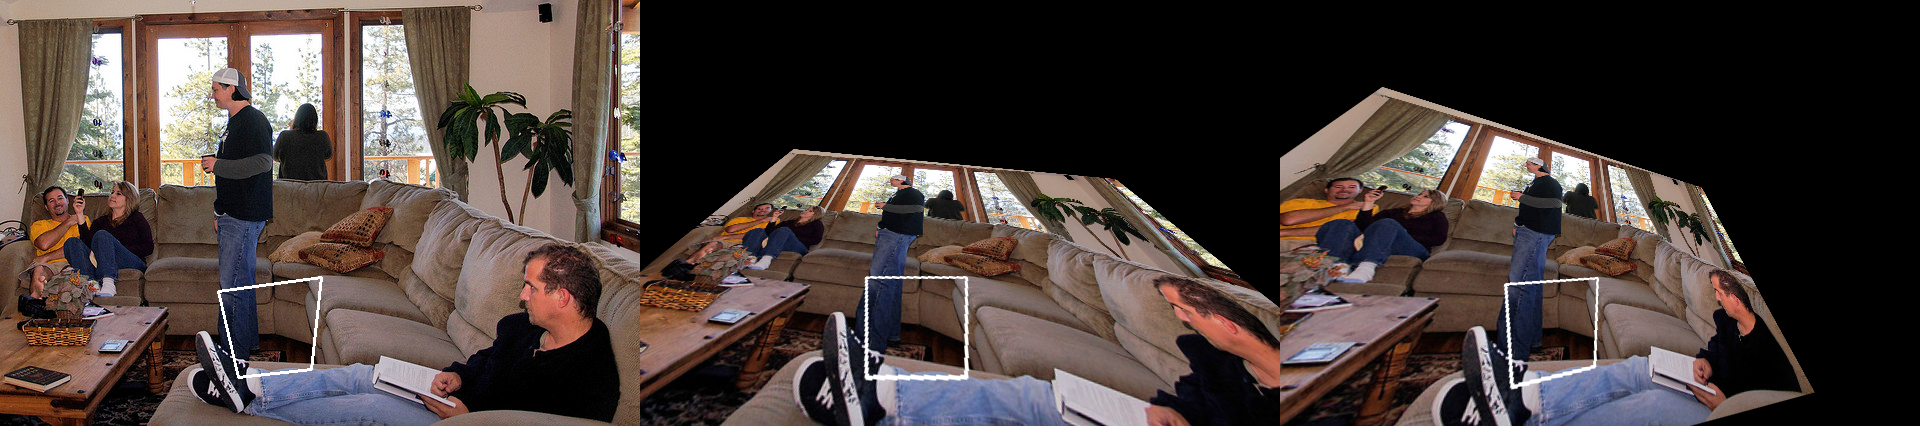

In [ ]:
import cv2
import os
import sys
import glob
import random
from skimage import data, exposure, img_as_float
import matplotlib.pyplot as plt
import numpy as np
import time
from torchvision.transforms import ToTensor
import argparse
import shutil
import string
import math as m
from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm
import torch
import pandas as pd
from google.colab.patches import cv2_imshow

def SetupAll():
    """
    Outputs:
    ImageSize - Size of the Image
    """
    # Image Input Shape
    ImageSize = [1,2, 100, 100]

    return ImageSize

def StandardizeInputs(Img):
    ##########################################################################
    # Add any standardization or cropping/resizing if used in Training here!
    ##########################################################################
    return Img

def ReadImages(Img):
    """
    Outputs:
    I1Combined - I1 image after any standardization and/or cropping/resizing to ImageSize
    I1 - Original I1 image for visualization purposes only
    """
    I1 = Img

    if(I1 is None):
        # OpenCV returns empty list if image is not read!
        print('ERROR: Image I1 cannot be read')
        sys.exit()

    I1S = StandardizeInputs(np.float32(I1))

    I1Combined = np.expand_dims(I1S, axis=0)

    return I1Combined, I1


def TestOperation(ImageSize, ModelPath, TestSet, LabelsPathPred):
    """
    Inputs:
    ImageSize is the size of the image
    ModelPath - Path to load trained model from
    TestSet - The test dataset
    LabelsPathPred - Path to save predictions
    Outputs:
    Predictions written to /content/data/TxtFiles/PredOut.txt
    """
    # Predict output with forward pass, MiniBatchSize for Test is 1
    model = HomographyModel()
    model.eval()
    CheckPoint = torch.load(ModelPath)
    model.load_state_dict(CheckPoint['model_state_dict'])
    print('Number of parameters in this model are %d ' % len(model.state_dict().items()))

    OutSaveT = open(LabelsPathPred, 'w')

    # for count in tqdm(range(len(TestSet))):
    # Img, Label = TestSet[count]
    # Img, ImgOrg = ReadImages(Img)
    PredT = model(TestSet).detach().numpy().reshape((4,2))

    OutSaveT.write(str(PredT)+'\n')
    OutSaveT.close()
    return PredT

def Accuracy(Pred, GT):
    """
    Inputs:
    Pred are the predicted labels
    GT are the ground truth labels
    Outputs:
    Accuracy in percentage
    """
    return (np.sum(np.array(Pred)==np.array(GT))*100.0/len(Pred))

def ReadLabels(LabelsPathTest, LabelsPathPred):
    if(not (os.path.isfile(LabelsPathTest))):
        print('ERROR: Test Labels do not exist in '+LabelsPathTest)
        sys.exit()
    else:
        LabelTest = open(LabelsPathTest, 'r')
        LabelTest = LabelTest.read()
        LabelTest = map(float, LabelTest.split())

    if(not (os.path.isfile(LabelsPathPred))):
        print('ERROR: Pred Labels do not exist in '+LabelsPathPred)
        sys.exit()
    else:
        LabelPred = open(LabelsPathPred, 'r')
        LabelPred = LabelPred.read()
        LabelPred = map(float, LabelPred.split())

    return LabelTest, LabelPred

def ConfusionMatrix(LabelsTrue, LabelsPred):
    """
    LabelsTrue - True labels
    LabelsPred - Predicted labels
    """

    # Get the confusion matrix using sklearn.
    LabelsTrue, LabelsPred = list(LabelsTrue), list(LabelsPred)
    cm = confusion_matrix(y_true=LabelsTrue,  # True class for test-set.
                          y_pred=LabelsPred)  # Predicted class.

    # Print the confusion matrix as text.
    for i in range(10):
        print(str(cm[i, :]) + ' ({0})'.format(i))

    # Print the class-numbers for easy reference.
    class_numbers = [" ({0})".format(i) for i in range(10)]
    print("".join(class_numbers))

    print('Accuracy: '+ str(Accuracy(LabelsPred, LabelsTrue)), '%')


ModelPath = "/content/drive/MyDrive/AutoPano/Phase2/Checkpoints/24model.ckpt"
LabelsPath = "/content/drive/MyDrive/AutoPano/Phase2/H4.csv"

image = cv2.imread('/content/drive/MyDrive/AutoPano/Phase2/Data/Train/970.jpg')
patchesA = "/content/drive/MyDrive/AutoPano/Phase2/Data/PatchA/970.jpg"
patchesB = "/content/drive/MyDrive/AutoPano/Phase2/Data/Patch_warped/970.jpg"
H4 = pd.read_csv('/content/drive/MyDrive/AutoPano/Phase2/H4.csv', index_col = False)
H4 = H4.to_numpy()
img1 = cv2.cvtColor(cv2.imread(patchesA), cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(cv2.imread(patchesB), cv2.COLOR_BGR2GRAY)
stack = np.float32(np.dstack((img1,img2)))
stack = np.transpose(stack, (2, 0, 1))
TestSet = torch.reshape(torch.from_numpy(stack), (1,2,100,100))
print(TestSet.shape)
# Setup all needed parameters including file reading
ImageSize = SetupAll()

# Define PlaceHolder variables for Input and Predicted output
LabelsPathPred = '/content/drive/MyDrive/AutoPano/Phase2/PredOut.txt' # Path to save predicted labels

h4pt_pred = TestOperation(ImageSize, ModelPath, TestSet, LabelsPathPred)


print("Predicted :")
print(h4pt_pred)
H4_actual = H4[2570].reshape((4,2))
print("Actual :")
print(H4_actual)
corners_list = np.load('/content/drive/MyDrive/AutoPano/Phase2/origpointsList.npy')
pts2 = np.load('/content/drive/MyDrive/AutoPano/Phase2/warpedpointsList.npy')
pts2 = pts2[140].reshape((4,2)).astype(np.float32)
corners = corners_list[140]
corners_warped_pred = corners + h4pt_pred
corners_warped = corners + H4_actual

# Src and Dest of pred
src_points = corners.reshape((4,2)).astype(np.float32)
dst_points = corners_warped_pred.reshape((4, 2)).astype(np.float32)

# Src and Dest ground truth
dst_points1 = corners_warped.reshape((4, 2)).astype(np.float32)


# Find perspective transformation matrix
M_pred = cv2.getPerspectiveTransform(src_points, dst_points)
M_actual = cv2.getPerspectiveTransform(src_points,dst_points1)
# Use the transformation matrix to warp an image
pts2 = [(int(pt[0]), int(pt[1])) for pt in pts2]

dst_points1 = [(int(pt[0]), int(pt[1])) for pt in dst_points1]
cv2.line(image, tuple(dst_points1[0]), tuple(dst_points1[1]), (255, 255, 255), 2)
cv2.line(image, tuple(dst_points1[1]), tuple(dst_points1[3]), (255, 255, 255), 2)
cv2.line(image, tuple(dst_points1[3]), tuple(dst_points1[2]), (255, 255, 255), 2)
cv2.line(image, tuple(dst_points1[2]), tuple(dst_points1[0]), (255, 255, 255), 2)


warped_img_pred = cv2.warpPerspective(image, np.linalg.inv(M_pred), (image.shape[1], image.shape[0])) #, image.shape[2]))
warped_img_actual = cv2.warpPerspective(image,np.linalg.inv(M_actual), (image.shape[1], image.shape[0])) #, image.shape[2]))


dst_points = [(int(pt[0]), int(pt[1])) for pt in dst_points]


concatenated_image = np.concatenate((image, warped_img_actual, warped_img_pred), axis=1)

cv2_imshow(concatenated_image)

# # Plot Confusion Matrix
# LabelsTrue, LabelsPred = ReadLabels(LabelsPath, LabelsPathPred)
# ConfusionMatrix(LabelsTrue, LabelsPred)

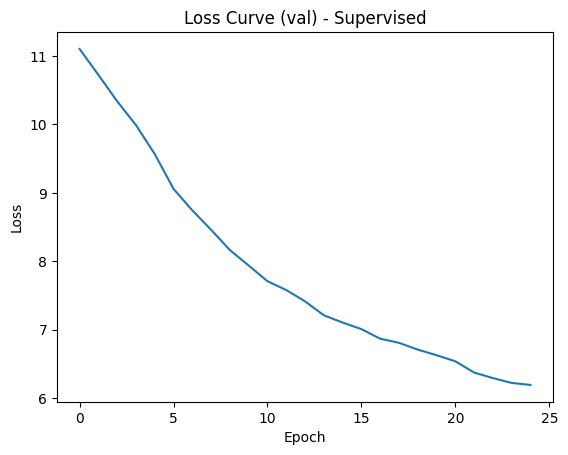

In [ ]:
import matplotlib.pyplot as plt

# Read loss values from the .txt file
with open("/content/drive/MyDrive/AutoPano/Phase2/val_supervised_25_64.txt", "r") as file:
    lines = file.readlines()

# Filter out blank spaces and lines, and convert to float
loss_values = np.array([float(line.strip()) for line in lines if line.strip()])
loss_values = loss_values*100
# np.savetxt('/content/drive/MyDrive/AutoPano/Phase2/supervised_25_64.txt', loss_values)

# Plot the loss curve
plt.plot(loss_values)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve (val) - Supervised")
plt.show()